In [1]:
import os
import cv2
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-5
BATCH_SIZE = 32
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = True

In [2]:
DATA_PATH = "data/kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DATA_PATH, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [3]:
"""
Data directory for the masks and images
Format is TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Each image is a slice MRI scan of the patient's brain, with a mask showing tumor area if present
"""
masks[:5], images[:5]

(['TCGA_HT_7690_19960312_19_mask.tif',
  'TCGA_HT_7690_19960312_15_mask.tif',
  'TCGA_HT_7690_19960312_3_mask.tif',
  'TCGA_HT_7690_19960312_17_mask.tif',
  'TCGA_HT_7690_19960312_18_mask.tif'],
 ['TCGA_HT_7690_19960312_19.tif',
  'TCGA_HT_7690_19960312_15.tif',
  'TCGA_HT_7690_19960312_3.tif',
  'TCGA_HT_7690_19960312_17.tif',
  'TCGA_HT_7690_19960312_18.tif'])

In [4]:
# Amount of data we are dealing with
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [5]:
# Create dataframe of each image location
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})
imagePath_df['image-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['masks']
imagePath_df.head()

,directory,images,masks,image-path,mask-path
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_19.tif,TCGA_HT_7690_19960312_19_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_15.tif,TCGA_HT_7690_19960312_15_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_3.tif,TCGA_HT_7690_19960312_3_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...,data/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7...


In [6]:
# Show image shape
imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['images'].iloc[0])
maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['masks'].iloc[0])
image = cv2.imread(imagePath)
mask = cv2.imread(maskPath)

image.shape, mask.shape

((256, 256, 3), (256, 256, 3))

In [7]:
def plot_image(i):

    imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['images'].iloc[i])
    maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['masks'].iloc[i])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.4)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

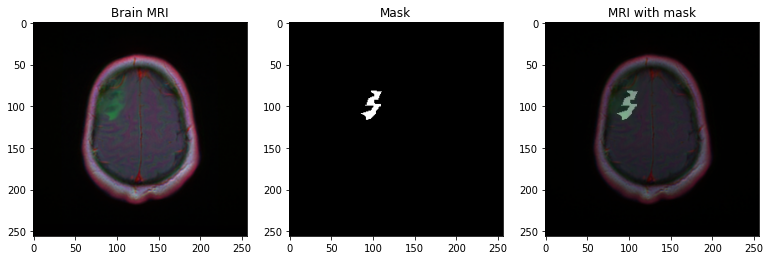

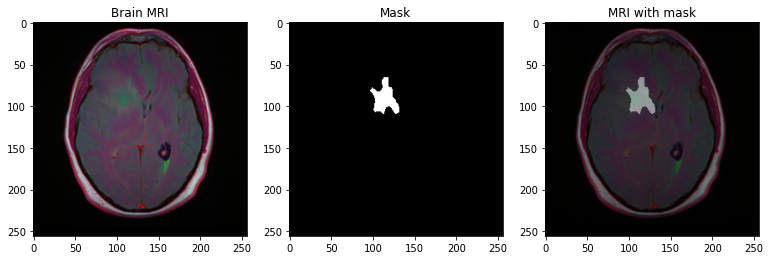

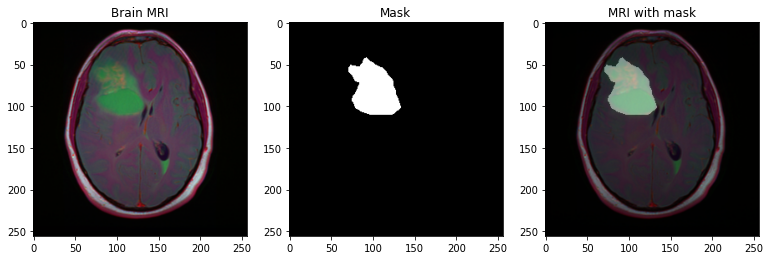

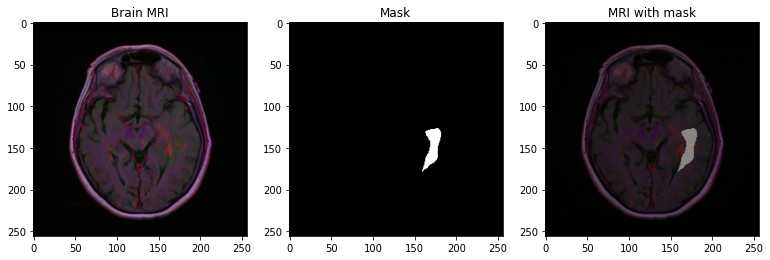

In [8]:
# Plot some example images
sample_images = [5,8,13,24]
for i in sample_images:
    plot_image(i)

In [9]:
train , test = train_test_split(imagePath_df, test_size=0.2)

In [10]:
# Training samples vs testing samples
len(train), len(test)

(3143, 786)

In [11]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        self.images = list(image_list)
        self.masks = list(mask_list)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.array(Image.open(self.images[index]).convert("RGB"))
        mask = np.array(Image.open(self.masks[index]).convert("L")).astype(np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [12]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [13]:
train_ds = BrainMRIDataset(
    image_list=list(train["image-path"]),
    mask_list=list(train["mask-path"]),
    transform=train_transform,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = BrainMRIDataset(
    image_list=list(test["image-path"]),
    mask_list=list(test["mask-path"]),
    transform=val_transform,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

Now we move on to defining the neural network, here is a basic network structure:
![UNet](UNet.png)

In [14]:
# First define the double convolution layer for u-net down
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [15]:
class UNET(nn.Module):
    def __init__(
        self, 
        in_channels=3, 
        out_channels=1, 
        features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # Lowest layer connecting up and down processes
        self.bottom_u = DoubleConv(features[-1], features[-1]*2)
        
        # Final convolution layer to output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom_u(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [16]:
# Define unet and move to GPU
unet = UNET(in_channels = 3, out_channels = 1)
unet.to(DEVICE)
# Batch size 1, 3 color channels, 256x256 image
test_forward = unet(torch.randn((1, 3, 256, 256)).cuda())
test_forward.shape

/usr/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 256, 256])

In [17]:
# Define checkpoint saving

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [18]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    score = dice_score/len(loader)
    print(f"Dice score: {score}")
    model.train()
    return score

In [19]:
def generate_predictions(
    loader, model, device="cuda"
):
    model.eval()
    predictions = []
    for x, y in loader:
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float().cpu()
            predictions.append((preds, y))
    return predictions

In [20]:
def plot_image(predictions, index):
    
    fig, axs = plt.subplots(1,5, figsize=[13,15])
    
    axs[0].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(predictions[0][1][index])
    axs[1].set_title('Tumor')
    
    axs[2].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[2].imshow(predictions[0][1][index], alpha=0.4)
    axs[2].set_title('Brain with tumor')
    
    axs[4].imshow(predictions[0][0][index].permute(1, 2, 0))
    axs[4].set_title('Predicted tumor')
    
    axs[3].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[3].imshow(predictions[0][0][index].permute(1, 2, 0), alpha=0.4)
    axs[3].set_title('Brain with predicted tumor')
    
    plt.grid(False)
    plt.show()

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [22]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [23]:
# 20 epochs
score = 0
accuracy = []
for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, unet, optimizer, loss_fn, scaler)

        # check accuracy
        new_score = check_accuracy(val_loader, unet, device=DEVICE)
        accuracy.append(new_score)
        
        if (new_score > score):
            print("better model, saving...")
            # save model
            checkpoint = {
                "state_dict": unet.state_dict(),
                "optimizer":optimizer.state_dict(),
            }
            save_checkpoint(checkpoint)
            score = new_score
        else:
            print("over-fitting possibility, skipping...")

100%|██████████| 99/99 [00:41<00:00,  2.39it/s, loss=0.56] 


Got 47714905/51511296 with acc 92.63
Dice score: 0.17389899492263794
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:44<00:00,  2.23it/s, loss=0.412]


Got 51131398/51511296 with acc 99.26
Dice score: 0.596707820892334
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:45<00:00,  2.16it/s, loss=0.394]


Got 51220012/51511296 with acc 99.43
Dice score: 0.6996471285820007
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.15it/s, loss=0.367]


Got 51260392/51511296 with acc 99.51
Dice score: 0.731938362121582
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51217529/51511296 with acc 99.43
Dice score: 0.7213163375854492
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51216721/51511296 with acc 99.43
Dice score: 0.7143839001655579
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:46<00:00,  2.13it/s, loss=0.341]


Got 51268697/51511296 with acc 99.53
Dice score: 0.7564139366149902
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.13it/s, loss=0.33] 


Got 51282203/51511296 with acc 99.56
Dice score: 0.7591165900230408
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.13it/s, loss=0.321]


Got 51290846/51511296 with acc 99.57
Dice score: 0.7663475871086121
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.12it/s, loss=0.319]


Got 51291696/51511296 with acc 99.57
Dice score: 0.7800642251968384
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51280120/51511296 with acc 99.55
Dice score: 0.77894526720047
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51268225/51511296 with acc 99.53
Dice score: 0.7746524810791016
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:46<00:00,  2.13it/s, loss=0.297]


Got 51295058/51511296 with acc 99.58
Dice score: 0.7881467342376709
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.13it/s, loss=0.328]


Got 51324897/51511296 with acc 99.64
Dice score: 0.8222379684448242
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51298320/51511296 with acc 99.59
Dice score: 0.8035153150558472
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:46<00:00,  2.12it/s, loss=0.288]


Got 51339745/51511296 with acc 99.67
Dice score: 0.8299586772918701
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.14it/s, loss=0.273]


Got 51342806/51511296 with acc 99.67
Dice score: 0.8402718305587769
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.13it/s, loss=0.266]


Got 51350674/51511296 with acc 99.69
Dice score: 0.8439584374427795
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.13it/s, loss=0.279]


Got 51361938/51511296 with acc 99.71
Dice score: 0.8491601347923279
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:46<00:00,  2.12it/s, loss=0.258]


Got 51132781/51511296 with acc 99.27
Dice score: 0.7059323191642761
over-fitting possibility, skipping...


In [24]:
# Load best model

load_checkpoint(torch.load("my_checkpoint.pth.tar"), unet)

=> Loading checkpoint


In [25]:
predictions = generate_predictions(val_loader, unet)

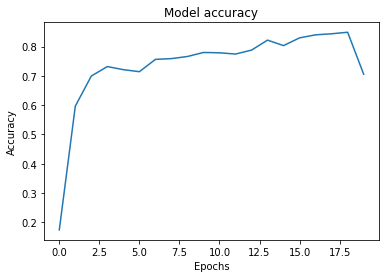

[tensor(0.1739), tensor(0.5967), tensor(0.6996), tensor(0.7319), tensor(0.7213), tensor(0.7144), tensor(0.7564), tensor(0.7591), tensor(0.7663), tensor(0.7801), tensor(0.7789), tensor(0.7747), tensor(0.7881), tensor(0.8222), tensor(0.8035), tensor(0.8300), tensor(0.8403), tensor(0.8440), tensor(0.8492), tensor(0.7059)]


In [27]:
cpu_accuracy = [elem.cpu() for elem in accuracy]
x = np.arange(0, len(accuracy))
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x, cpu_accuracy)
plt.show()
print(cpu_accuracy)

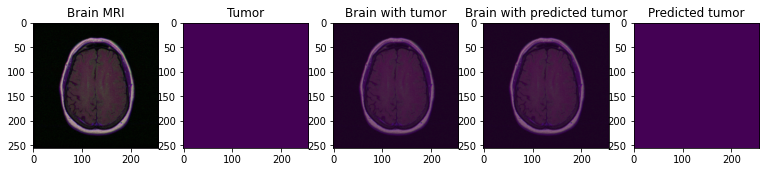

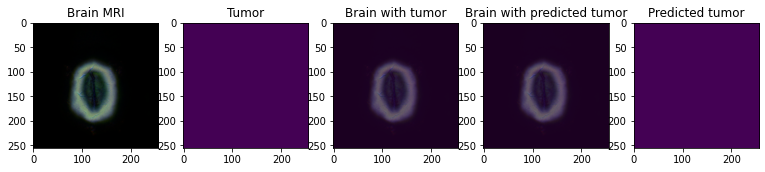

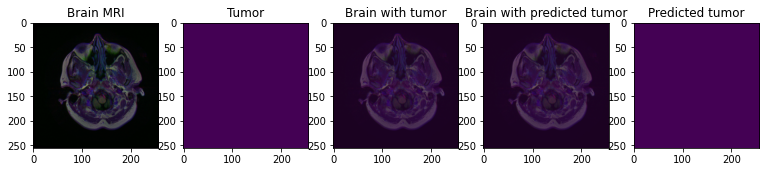

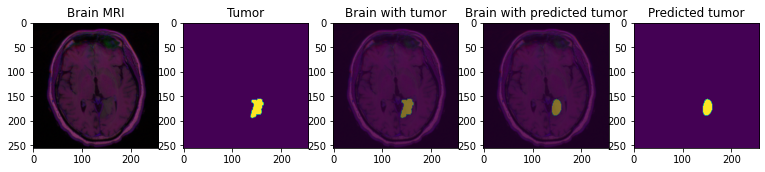

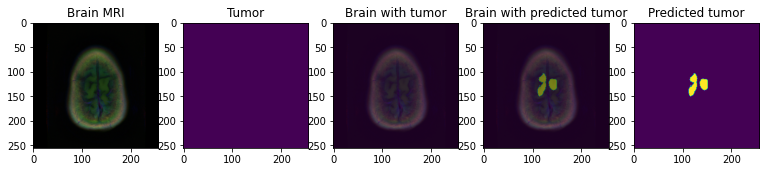

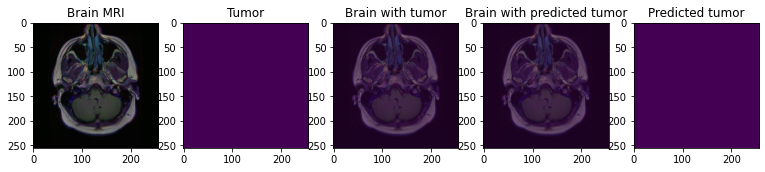

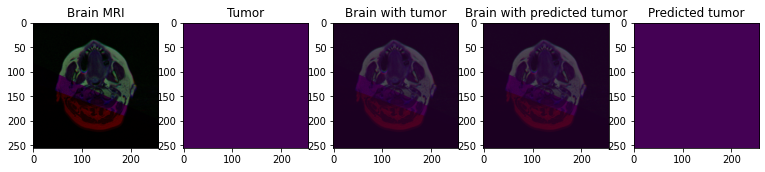

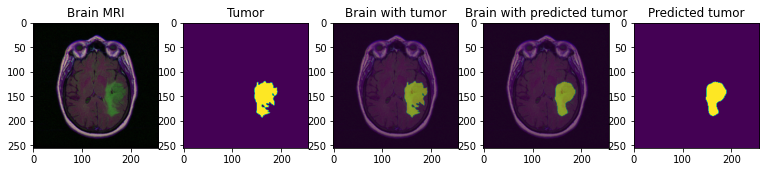

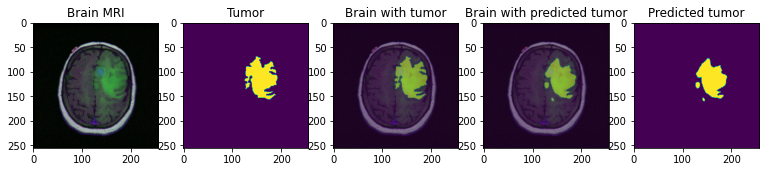

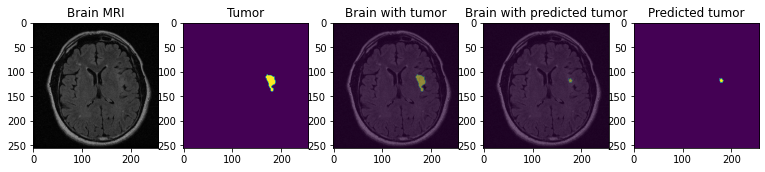

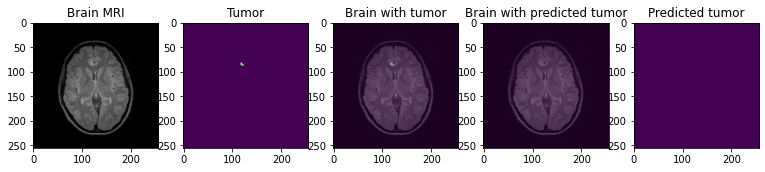

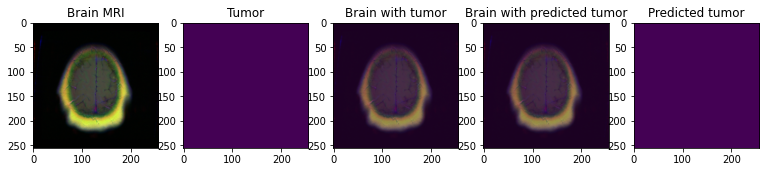

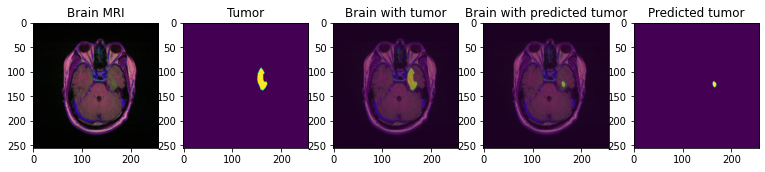

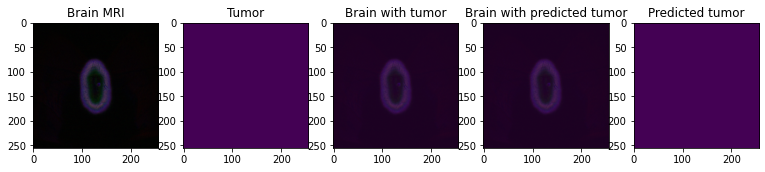

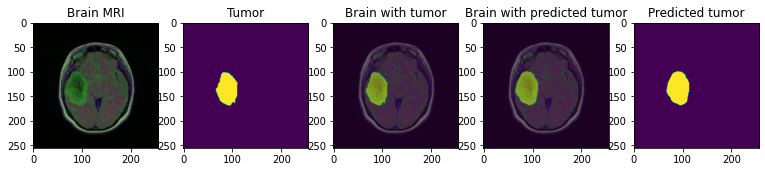

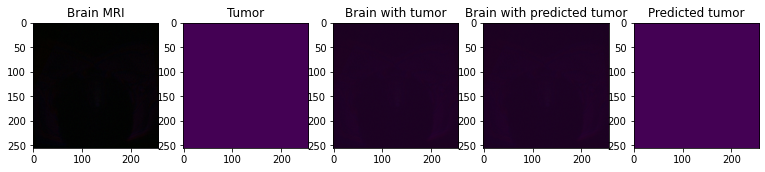

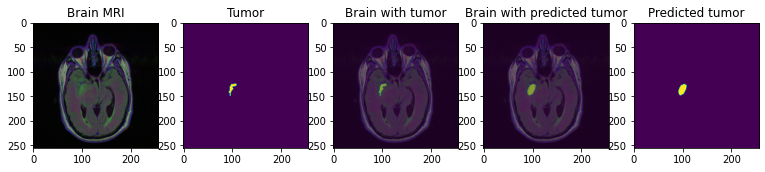

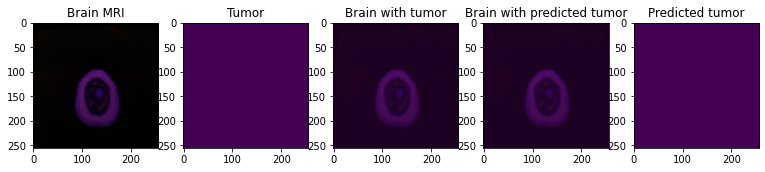

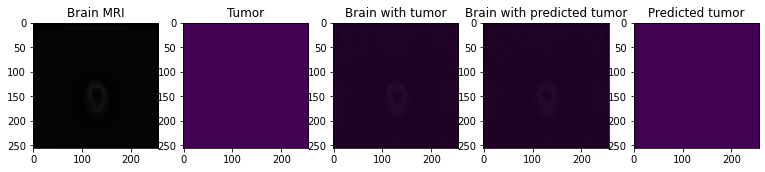

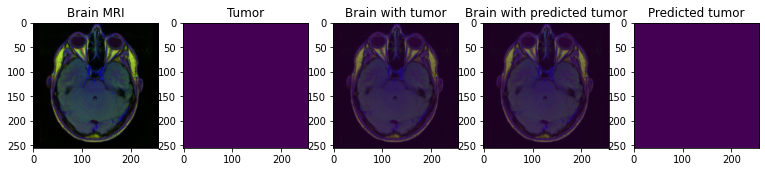

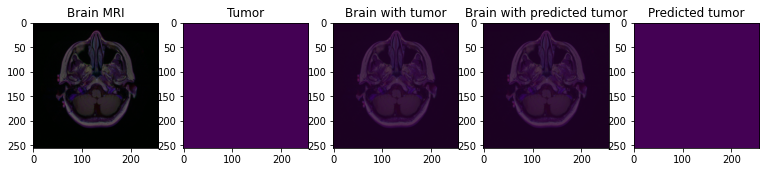

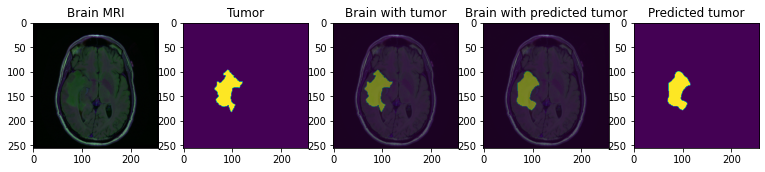

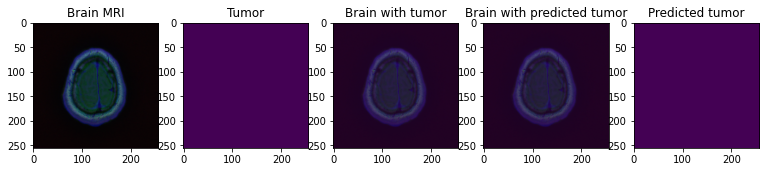

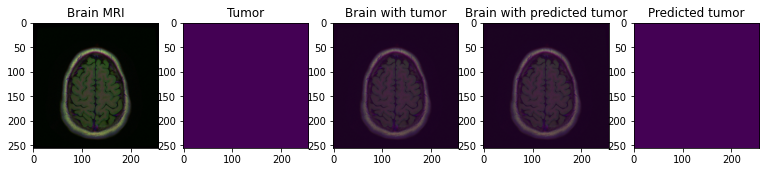

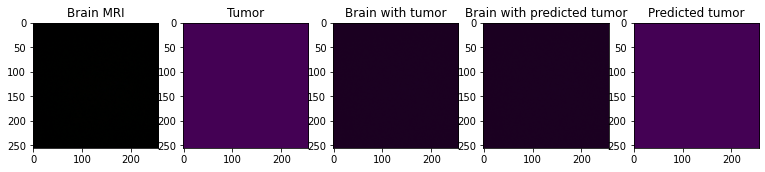

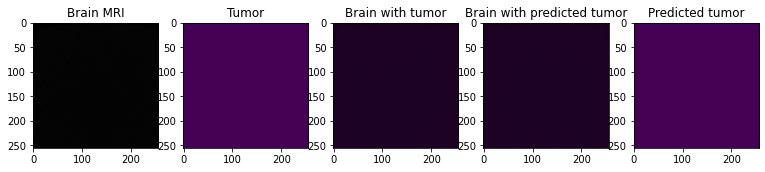

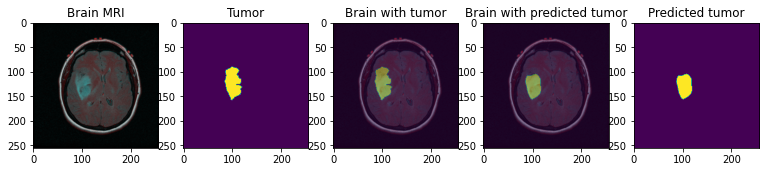

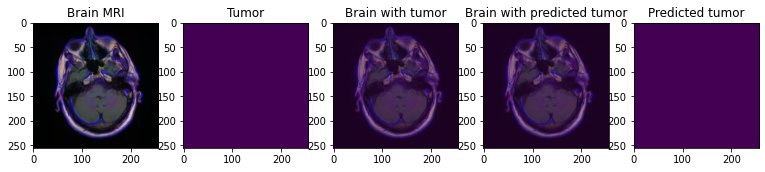

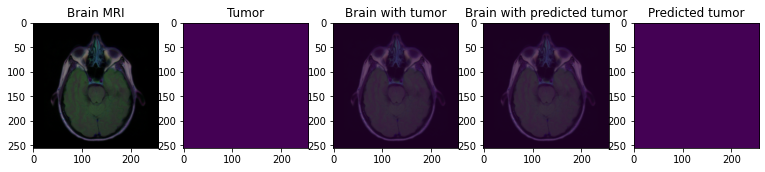

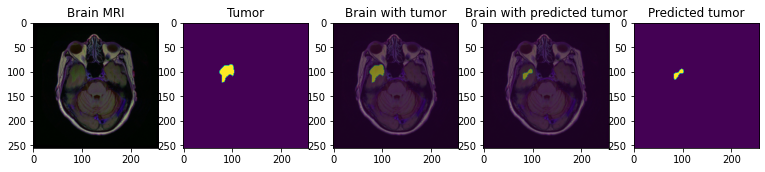

In [28]:
for i in range(30):
    plot_image(predictions, i)